In [10]:
import librosa
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import time
import glob
from lxml.html import parse
from sphfile import SPHFile
import pydub
import audiosegment
import pandas as pd
from collections import Counter
from bs4 import BeautifulSoup
import sys
import os
from tqdm.notebook import tqdm
from itertools import permutations
import torch
import torch.nn.functional as F
from librosa.core import resample
EPS = 1e-8
import pathlib
def create_dir(filename):
    pathlib.Path('/'.join(filename.split('/')[:-1])).mkdir(parents=True, exist_ok=True)
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x):
        return self.func(x)
old_sr = 16000
new_sr = 8000
dropout = 0.3
half = False
root = '../'

In [11]:
device = 0
device_ids = [0, 1, 2, 3]
torch.cuda.set_device(device)

[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]


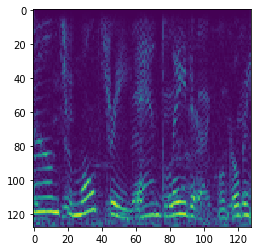

In [12]:
class OverlayDataSet(torch.utils.data.Dataset):
    def __init__(self, csv):
        super().__init__()
        self.segments = pd.read_csv(root+csv)
        self.speakers = list(set(self.segments['speaker']))
        self.speakers.sort()
        self.spkr2idx = {spkr:i for i, spkr in enumerate(self.speakers)}

    def __len__(self):
        return len(self.segments)
    def __getitem__(self, idx):
        seg1 = self.segments.iloc[idx]
        seg2 = self.segments.iloc[np.random.randint(len(self.segments))]
        while(seg1['speaker']==seg2['speaker']):
            seg2 = self.segments.iloc[np.random.randint(len(self.segments))]

        sig1 = np.load(root+seg1['segfile'])
        sig2 = np.load(root+seg2['segfile'])

        spec1 = np.log(1+make_spectrogram(sig1))[None, ...]
        spec2 = np.log(1+make_spectrogram(sig2))[None, ...]
        source = np.log(1+make_spectrogram(sig1+sig2))[None, ...]
        
        out_vec1 = np.zeros(len(self.speakers)) # maybe try PIT training too
        out_vec2 = np.zeros(len(self.speakers)) # maybe try PIT training too
        out_vec1[self.spkr2idx[seg1['speaker']]] = 1
        out_vec2[self.spkr2idx[seg2['speaker']]] = 1

        return source, np.concatenate((spec1, spec2), axis = 0), out_vec1, out_vec2


#mean, std = compute_mean_std('overlay-train.csv')


trainset = OverlayDataSet('train-segments.csv')
valset = OverlayDataSet('val-segments.csv')
testset = OverlayDataSet('test-segments.csv')
mixture, sources, target1, target2 = trainset[5]
plt.imshow(mixture[0][::-1])
print(target1, target2)

## Maybe try drastically increasing channel number in residual attention stage to see if it overfits

In [13]:
# import torch
import torch.nn as nn
from torch.nn import init
import functools
from torch.autograd import Variable
import numpy as np

class ResidualBlock(nn.Module):
    def __init__(self, input_channels, output_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.input_channels = input_channels
        self.output_channels = output_channels
        self.stride = stride
        self.bn1 = nn.BatchNorm2d(input_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(input_channels, output_channels, 1, 1, bias = False)
        self.bn2 = nn.BatchNorm2d(output_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(output_channels, output_channels, 3, stride, padding = 1, bias = False)
        self.bn3 = nn.BatchNorm2d(output_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv3 = nn.Conv2d(output_channels, output_channels, 1, 1, bias = False)
        self.conv4 = nn.Conv2d(input_channels, output_channels , 1, stride, bias = False)
        
    def forward(self, x):
        residual = x
        out = self.bn1(x)
        out1 = self.relu(out)
        out = self.conv1(out1)
        out = self.bn2(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn3(out)
        out = self.relu(out)
        out = self.conv3(out)
        if (self.input_channels != self.output_channels) or (self.stride !=1 ):
            residual = self.conv4(out1)
        out += residual
        return out

class AttentionModule_stage1(nn.Module):
    # input size is 56*56
    def __init__(self, in_channels, out_channels, size1=(128, 128), size2=(64, 64), size3=(32, 32), out_skip = True):
        super(AttentionModule_stage1, self).__init__()
        self.first_residual_blocks = ResidualBlock(in_channels, in_channels)

        self.trunk_branches = nn.Sequential(
            ResidualBlock(in_channels, in_channels),
            ResidualBlock(in_channels, in_channels)
         )

        self.mpool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.softmax1_blocks = ResidualBlock(in_channels, in_channels)

        self.skip1_connection_residual_block = ResidualBlock(in_channels, in_channels)

        self.mpool2 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.softmax2_blocks = ResidualBlock(in_channels, in_channels)

        self.skip2_connection_residual_block = ResidualBlock(in_channels, in_channels)

        self.mpool3 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.softmax3_blocks = nn.Sequential(
            ResidualBlock(in_channels, in_channels),
            ResidualBlock(in_channels, in_channels)
        )

        self.interpolation3 = nn.UpsamplingBilinear2d(size=size3)

        self.softmax4_blocks = ResidualBlock(in_channels, in_channels)

        self.interpolation2 = nn.UpsamplingBilinear2d(size=size2)

        self.softmax5_blocks = ResidualBlock(in_channels, in_channels)

        self.interpolation1 = nn.UpsamplingBilinear2d(size=size1)

        self.softmax6_blocks = nn.Sequential(
            nn.BatchNorm2d(in_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels, in_channels , kernel_size = 1, stride = 1, bias = False),
            nn.BatchNorm2d(in_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels, in_channels , kernel_size = 1, stride = 1, bias = False),
            nn.Sigmoid()
        )

        self.last_blocks = ResidualBlock(in_channels, out_channels)
        self.out_skip = out_skip
        
    def forward(self, x):
        #batch_size, nheads, length, n_mels = x.shape
        x = self.first_residual_blocks(x)
        out_trunk = self.trunk_branches(x)
        out_mpool1 = self.mpool1(x) # 100x64
        out_softmax1 = self.softmax1_blocks(out_mpool1)
        out_skip1_connection = self.skip1_connection_residual_block(out_softmax1)
        out_mpool2 = self.mpool2(out_softmax1) # 50x32
        out_softmax2 = self.softmax2_blocks(out_mpool2)
        out_skip2_connection = self.skip2_connection_residual_block(out_softmax2)
        out_mpool3 = self.mpool3(out_softmax2) # 25x16
        out_softmax3 = self.softmax3_blocks(out_mpool3) 
        out_interp3 = self.interpolation3(out_softmax3) + out_softmax2
        out = out_interp3 + out_skip2_connection
        out_softmax4 = self.softmax4_blocks(out)
        out_interp2 = self.interpolation2(out_softmax4) + out_softmax1
        out = out_interp2 + out_skip1_connection
        out_softmax5 = self.softmax5_blocks(out)
        out_interp1 = self.interpolation1(out_softmax5) + out_trunk
        out_softmax6 = self.softmax6_blocks(out_interp1)
        if self.out_skip:
            out = (1 + out_softmax6) * out_trunk
        else:
            out = out_softmax6 * out_trunk
        out_last = self.last_blocks(out)
        return out_last

num_heads_2 = 4 # MHA heads

In [14]:
class DepthwiseSeparableConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size,
                 stride, padding, dilation):
        super(DepthwiseSeparableConv, self).__init__()
        # Use `groups` option to implement depthwise convolution
        # [M, H, K] -> [M, H, K]
        depthwise_conv = nn.Conv2d(in_channels, in_channels, kernel_size,
                                   stride=stride, dilation = dilation, padding=padding, groups=in_channels,
                                   bias=False)

        prelu = nn.PReLU()
        norm = nn.BatchNorm2d(in_channels)
        # [M, H, K] -> [M, B, K]
        pointwise_conv = nn.Conv2d(in_channels, out_channels, 1, bias=False)
        # Put together
        self.net = nn.Sequential(depthwise_conv, prelu, norm, pointwise_conv)

    def forward(self, x):
        """
        Args:
            x: [M, H, K]
        Returns:
            result: [M, B, K]
        """
        return self.net(x)

class ResDilationBlock(nn.Module):
    def __init__(self, input_channels, output_channels):
        super(ResDilationBlock, self).__init__()
        self.bn1 = nn.BatchNorm2d(input_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(input_channels, input_channels, 3, padding = 1, bias = False, dilation = 1)
        self.bn2 = nn.BatchNorm2d(input_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(input_channels, input_channels, 3, padding = 2, bias = False, dilation = 2)
        self.bn3 = nn.BatchNorm2d(input_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv3 = nn.Conv2d(input_channels, input_channels, 3, padding = 4, bias = False, dilation = 4)
        self.bn4 = nn.BatchNorm2d(input_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv4 = nn.Conv2d(input_channels, input_channels, 3, padding = 8, bias = False, dilation = 8)
        self.bn5 = nn.BatchNorm2d(input_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv5 = nn.Conv2d(input_channels, input_channels, 3, padding = 16, bias = False, dilation = 16)
        self.bn6 = nn.BatchNorm2d(input_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv6 = nn.Conv2d(input_channels, input_channels, 3, padding = 32, bias = False, dilation = 32)
        self.bn7 = nn.BatchNorm2d(input_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv7 = nn.Conv2d(input_channels, output_channels, 1, bias = False)
        
    def forward(self, x):
        residual = x
        out = self.bn1(x)
        out = self.relu(out)
        out = self.conv1(out)
        out = self.bn2(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn3(out)
        out = self.relu(out)
        out = self.conv3(out)
        out += residual
        residual = out
        out = self.bn4(out)
        out = self.relu(out)
        out = self.conv4(out)
        out = self.bn5(out)
        out = self.relu(out)
        out = self.conv5(out)
        out = self.bn6(out)
        out = self.relu(out)
        out = self.conv6(out)
        out += residual
        out = self.bn7(out)
        out = self.relu(out)
        out = self.conv7(out)
        
        return out

In [15]:
load_model = True
model_to_load = 'models/extractor.pth'
num_speakers = 2
extractor = nn.Sequential(ResidualBlock(1, 128),
                          ResDilationBlock(128, 64),
                          ResDilationBlock(64, 64), # largest dilation is 32
                          ResDilationBlock(64, 64), # largest dilation is 32
                          ResDilationBlock(64, 128),
                          ResDilationBlock(128, num_speakers), # largest dilation is 32
                          nn.ReLU()
                         ).cuda(device)

optimizer = torch.optim.Adam(extractor.parameters(), 0.001)

if load_model and os.path.exists(model_to_load):
    print('load model')
    checkpoint = torch.load(model_to_load)
    extractor.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    #loss = checkpoint['loss']
    bestloss = checkpoint['bestloss']
else:
    print('initializing new model')
    bestloss = 999
print('bestloss', bestloss)

extractor = torch.nn.DataParallel(extractor, device_ids = device_ids)

initializing new model
bestloss 999


In [16]:
def cal_loss(source, estimate_source):
    """
    Args:
        source: [B, C, T, F], B is batch size, F is frequency
        estimate_source: [B, C, T, F]
        source_lengths: [B, F]
    """
    min_mse, perms, min_mse_idx = cal_mse(source,estimate_source)
    loss = torch.mean(min_mse)
    reorder_estimate_source = reorder_source(estimate_source, perms, min_mse_idx)
    return loss, min_mse, estimate_source, reorder_estimate_source


def cal_mse(source, estimate_source):
    """Calculate SI-SNR with PIT training.
    Args:
        source: [B, C, T, F], B is batch size
        estimate_source: [B, C, T, F]
        source_lengths: [B], each item is between [0, T]
    """
    assert source.size() == estimate_source.size()
    B, C, T, F = source.size()


    # Step 2. SI-SNR with PIT
    # reshape to use broadcast
    s_target = torch.unsqueeze(source, dim=1)  # [B, 1, C, T, F]
    s_estimate = torch.unsqueeze(estimate_source, dim=2)  # [B, C, 1, T, F]
    # s_target = <s', s>s / ||s||^2
    pair_wise_mse = torch.sum((s_estimate - s_target)**2, dim=(3, 4))/T/F  # [B, C, C]

    ############## since distribution is asymmetric, use l2 not l1 loss ###########
    
    # Get max_snr of each utterance
    # permutations, [C!, C]
    perms = source.new_tensor(list(permutations(range(C))), dtype=torch.long)
    # one-hot, [C!, C, C]
    index = torch.unsqueeze(perms, 2)
    perms_one_hot = source.new_zeros((*perms.size(), C)).scatter_(2, index, 1)
    # [B, C!] <- [B, C, C] einsum [C!, C, C], SI-SNR sum of each permutation
    mse_set = torch.einsum('bij,pij->bp', [pair_wise_mse, perms_one_hot])
    min_mse_idx = torch.argmin(mse_set, dim=1)  # [B]
    # max_snr = torch.gather(snr_set, 1, max_snr_idx.view(-1, 1))  # [B, 1]
    min_mse, _ = torch.min(mse_set, dim=1, keepdim=True)
    min_mse /= C
    return min_mse, perms, min_mse_idx


def reorder_source(source, perms, max_snr_idx):
    """
    Args:
        source: [B, C, T]
        perms: [C!, C], permutations
        max_snr_idx: [B], each item is between [0, C!)
    Returns:
        reorder_source: [B, C, T]
    """
    B, C, *_ = source.size()
    # [B, C], permutation whose SI-SNR is max of each utterance
    # for each utterance, reorder estimate source according this permutation
    max_snr_perm = torch.index_select(perms, dim=0, index=max_snr_idx)
    # print('max_snr_perm', max_snr_perm)
    # maybe use torch.gather()/index_select()/scatter() to impl this?
    reorder_source = torch.zeros_like(source)
    for b in range(B):
        for c in range(C):
            reorder_source[b, c] = source[b, max_snr_perm[b][c]]
    return reorder_source





## If it turns out magnitude instability causes a problem, try adding a residual connection of envelope near output layer

In [17]:
batch_size = 32
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, pin_memory = True, num_workers = 16)
valloader = torch.utils.data.DataLoader(valset, batch_size=32, shuffle=True, pin_memory = True, num_workers = 16)
criterion = torch.nn.BCELoss()

for epoch in range(64):
    running_loss = 0.0
    extractor.train()
    for batch_idx, (mixture, targets, _, _) in enumerate(tqdm(trainloader)):
        optimizer.zero_grad()
        mixture, targets = mixture.float().cuda(device), targets.float().cuda(device)
        outs = extractor(mixture)
        loss, min_mse, estimate_targets, reorder_estimate_targets = cal_loss(targets, outs)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(extractor.parameters(), 0.5)
        optimizer.step()

        running_loss += loss.item()
        if batch_idx % 200 == 199:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.4f ' % 
                  (epoch + 1, batch_idx + 1, running_loss / 200))
            running_loss = 0.0
            torch.save({
            'model_state_dict': extractor.module.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            'bestloss': bestloss
            }, 'models/extractor.pth')
            
    
    extractor.eval()
    running_loss = 0.0
    with torch.no_grad():
        for batch_idx, (mixture, targets, _, _) in enumerate(tqdm(valloader)):
            num_samples = mixture.shape[0]
            mixture, targets = mixture.float().cuda(device), targets.float().cuda(device)
            outs = extractor(mixture)
            loss, min_mse, estimate_targets, reorder_estimate_targets = cal_loss(targets, outs)
            running_loss += loss.item()*num_samples
            
        running_loss /= len(valset)
        print('val loss: %.3f ' % (running_loss))
        
        if running_loss < bestloss:
            bestloss = running_loss
            torch.save({
            'model_state_dict': extractor.module.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'bestloss': bestloss
            }, 'models/best-extractor.pth')

# extractor = nn.Sequential(ResidualBlock(1, 128),
#                           ResDilationBlock(128, 64),
#                           ResDilationBlock(64, 64), # largest dilation is 32
#                           ResDilationBlock(64, 64), # largest dilation is 32
#                           ResDilationBlock(64, 128),
#                           ResDilationBlock(128, num_speakers), # largest dilation is 32
#                           nn.ReLU()
#                          ).cuda(device)

[1,   200] loss: 0.0657 
[1,   400] loss: 0.0437 
[1,   600] loss: 0.0394 
[1,   800] loss: 0.0354 
[1,  1000] loss: 0.0347 
[1,  1200] loss: 0.0332 




val loss: 0.037 


[2,   200] loss: 0.0316 
[2,   400] loss: 0.0302 
[2,   600] loss: 0.0300 
[2,   800] loss: 0.0276 
[2,  1000] loss: 0.0281 
[2,  1200] loss: 0.0276 




val loss: 0.030 


[3,   200] loss: 0.0265 
[3,   400] loss: 0.0254 
[3,   600] loss: 0.0259 
[3,   800] loss: 0.0255 
[3,  1000] loss: 0.0264 
[3,  1200] loss: 0.0254 




val loss: 0.025 


[4,   200] loss: 0.0241 
[4,   400] loss: 0.0232 
[4,   600] loss: 0.0232 
[4,   800] loss: 0.0226 
[4,  1000] loss: 0.0227 
[4,  1200] loss: 0.0236 




val loss: 0.027 


[5,   200] loss: 0.0225 
[5,   400] loss: 0.0221 
[5,   600] loss: 0.0226 
[5,   800] loss: 0.0226 
[5,  1000] loss: 0.0217 
[5,  1200] loss: 0.0220 




val loss: 0.023 


[6,   200] loss: 0.0223 
[6,   400] loss: 0.0221 
[6,   600] loss: 0.0207 
[6,   800] loss: 0.0200 
[6,  1000] loss: 0.0209 
[6,  1200] loss: 0.0210 




val loss: 0.023 


[7,   200] loss: 0.0207 
[7,   400] loss: 0.0208 
[7,   600] loss: 0.0215 
[7,   800] loss: 0.0194 
[7,  1000] loss: 0.0200 
[7,  1200] loss: 0.0200 




val loss: 0.021 


[8,   200] loss: 0.0202 
[8,   400] loss: 0.0196 
[8,   600] loss: 0.0203 
[8,   800] loss: 0.0202 
[8,  1000] loss: 0.0198 
[8,  1200] loss: 0.0192 




val loss: 0.020 


[9,   200] loss: 0.0192 
[9,   400] loss: 0.0183 
[9,   600] loss: 0.0197 
[9,   800] loss: 0.0195 
[9,  1000] loss: 0.0196 
[9,  1200] loss: 0.0193 




val loss: 0.020 


[10,   200] loss: 0.0191 
[10,   400] loss: 0.0180 
[10,   600] loss: 0.0184 
[10,   800] loss: 0.0183 
[10,  1000] loss: 0.0209 
[10,  1200] loss: 0.0189 




val loss: 0.019 


[11,   200] loss: 0.0192 
[11,   400] loss: 0.0182 
[11,   600] loss: 0.0193 
[11,   800] loss: 0.0203 
[11,  1000] loss: 0.0187 
[11,  1200] loss: 0.0193 




val loss: 0.022 


[12,   200] loss: 0.0185 
[12,   400] loss: 0.0182 
[12,   600] loss: 0.0180 
[12,   800] loss: 0.0190 
[12,  1000] loss: 0.0193 
[12,  1200] loss: 0.0186 




val loss: 0.020 


[13,   200] loss: 0.0181 
[13,   400] loss: 0.0174 
[13,   600] loss: 0.0174 
[13,   800] loss: 0.0196 
[13,  1000] loss: 0.0177 
[13,  1200] loss: 0.0189 




val loss: 0.027 


[14,   200] loss: 0.0192 
[14,   400] loss: 0.0171 
[14,   600] loss: 0.0179 
[14,   800] loss: 0.0171 
[14,  1000] loss: 0.0177 


KeyboardInterrupt: 

0.019426389535552303


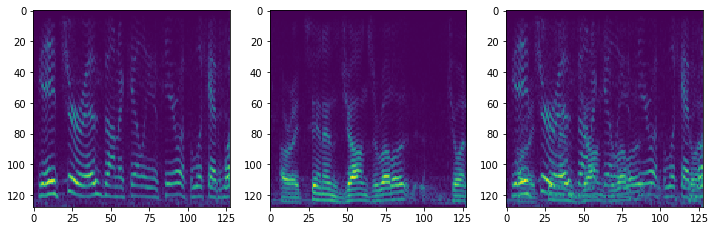

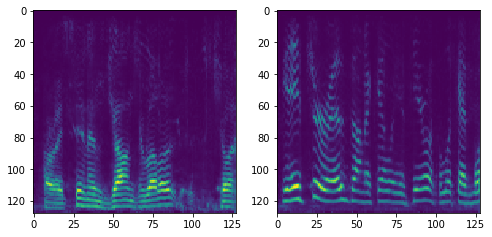

In [39]:
checkpoint = torch.load('models/best-extractor.pth')
extractor.module.load_state_dict(checkpoint['model_state_dict'])
print(checkpoint['bestloss'])
mixture, targets = testset[10]
plt.figure(figsize = (12, 4))
plt.subplot(131)
plt.imshow(targets[0][::-1])
plt.subplot(132)
plt.imshow(targets[1][::-1])
plt.subplot(133)
plt.imshow(mixture[0][::-1])

new_spec1, new_spec2 = extractor(torch.Tensor(mixture[None, ...]).cuda(device))[0].detach().cpu().numpy()
plt.figure(figsize = (8, 4))
plt.subplot(121)
plt.imshow(new_spec1[::-1])
plt.subplot(122)
plt.imshow(new_spec2[::-1])

## Save output spectrograms